# Asset Allocation with Pytorch using Position Memory

 Goal of this notebook is to create a model to combine the signals from the various strategies to create an asset allocation neural network to outperform equally weighted, as Markowitz may not be appropriate as the signals may be to buy or sell the same asset therefore yielding a perfect correlation when active.

In [1]:
from loguru import logger
from matplotlib import pyplot as plt
import numpy as np
import os
import pandas as pd
from pathlib import Path
from sklearn.model_selection import train_test_split
import shutil
import time
from tqdm import tqdm
import typing as t

import viz_neural_network as viz_nn

In [2]:
from quantified_strategies import loss, ml_utils, plot_utils, strategy_utils, utils

2024-03-05 13:48:04.370 | INFO     | quantified_strategies.ml_utils:get_device:26 - Running on the CPU


In [3]:
CASH = "CASH"

In [4]:
ASSETS = ["SPY", "QQQ", "TN=F", CASH]
ASSETS = ["SPY", "QQQ", CASH]
ASSETS = ["VUSA.LSE", "CNX1.LSE", "SGLN.L", CASH]
ASSETS = ["VUSA.LSE", "CNX1.LSE", CASH]
# ASSETS = ["XLC", "XLE", "XLF", "XLI", "XLK", "XLP", "XLRE", "XLU", "XLY", "XLV", CASH]
# ASSETS = ["XLK", CASH]
# ASSETS = ["SPY", "TN=F", CASH]
assert CASH in ASSETS
ASSETS

['VUSA.LSE', 'CNX1.LSE', 'CASH']

In [5]:
ENTRY = "Adj Close"
# ENTRY = "Open"
DAY_AFTER = True
DAY_AFTER_STRATEGIES = ["buy_when_yields_are_low"]
# DAY_AFTER_STRATEGIES = ["buy_when_yields_are_low", "turn_around_tuesday_strategy", "short_term_reversal"]
RISK_FREE_RATE = 0.0

In [6]:
LONG_OVERNIGHT_COSTS_DICT = {
    "SPY": 0.507559 / 508.3,
    "QQQ": 0.113025 / 437,
    "IWM": 0.203752 / 204.00,
    "XLC": 0.020313 / 78.53,
    "XLE": 0.086145 / 86.25,
    "XLF": 0.040039 / 40.08,
    "XLI": 0.031045 / 120.00,
    "XLK": 0.053141 / 205.50,
    "XLP": 0.019255 / 74.47,
    "XLRE": 0.038212 / 38.28,
    "XLU": 0.015704 / 60.74,
    "XLY": 0.04701 / 181.00,
    "XLV": 0.038038 / 147.10,
}
SHORT_OVERNIGHT_COSTS_DICT = {
    "SPY": 0.127772 / 508.3,
    "QQQ": 0.089958 / 437,
    "IWM": 0.051292 / 204.00,
    "XLC": 0.016167 / 78.53,
    "XLE": 0.021686 / 86.25,
    "XLF": 0.010079 / 40.08,
    "XLI": 0.024709 / 120.00,
    "XLK": 0.042296 / 205.50,
    "XLP": 0.015325 / 74.47,
    "XLRE": 0.009619 / 38.28,
    "XLU": 0.012499 / 60.74,
    "XLY": 0.037416 / 181.00,
    "XLV": 0.030275 / 147.10,
}

In [7]:
# Temporary Values
BORROWING_COSTS = [0 / 10_000 for _ in ASSETS]
FIXED_COSTS = [0 / 10_000 for _ in ASSETS]
FIXED_COSTS = [5 / 10_000 for asset in ASSETS if asset != CASH] + [0.0]
VAR_COSTS = [0 / 10_000 for _ in ASSETS]
VAR_COSTS = [5 / 10_000 for asset in ASSETS if asset != CASH] + [0.0]

LONG_OVERNIGHT_COSTS = [LONG_OVERNIGHT_COSTS_DICT.get(asset, 0.0) for asset in ASSETS]
SHORT_OVERNIGHT_COSTS = [SHORT_OVERNIGHT_COSTS_DICT.get(asset, 0.0) for asset in ASSETS]

In [8]:
[cost * 10_000 for cost in SHORT_OVERNIGHT_COSTS]

[0.0, 0.0, 0.0]

## Dataset Collection

In [10]:
def get_data(assets: str | t.List[str], is_classification: bool = True) -> t.Tuple[pd.DataFrame, pd.DataFrame]:

    def get_y() -> pd.DataFrame:
        # ENTRY = "Adj Close"
        price_data = [strategy_utils.get_data(ticker=ticker, columns=ENTRY).to_frame(name=ticker) for ticker in assets if ticker != "CASH"]
        price_data = pd.concat(price_data, axis=1)
        return_data = price_data.pct_change()
        if CASH in assets:
            risk_free_rate = strategy_utils.get_data(ticker="^TNX", columns=ENTRY, source="yahoo").to_frame(name=CASH)
            # risk_free_rate = pd.DataFrame(RISK_FREE_RATE, index=return_data.index, columns=[CASH])
            risk_free_rate = (1 + risk_free_rate / 100) ** (1 / 252) - 1
            return_data[CASH] = risk_free_rate.reindex(index=return_data.index, method="ffill").bfill()
            # return_data[CASH] = 0.0
        return_data = return_data.shift(-1)

        return_data = return_data.dropna()

        if is_classification:
            return (return_data > 0).astype(int)
        
        return return_data

    def get_X() -> pd.DataFrame:
        strategy_returns = pd.read_csv(f"outputs/strategy_returns_alternative.csv", index_col=0, header=[0, 1, 2])
        # strategy_returns = pd.read_csv(f"outputs/strategy_returns.csv", index_col=0, header=[0, 1, 2])
        
        if DAY_AFTER:
            strategy_returns.loc[:, strategy_returns.columns.get_level_values(1).isin(DAY_AFTER_STRATEGIES)] = (
                strategy_returns.loc[:, strategy_returns.columns.get_level_values(1).isin(DAY_AFTER_STRATEGIES)].shift(1))
            strategy_returns = strategy_returns.loc[:, ~strategy_returns.columns.get_level_values(1).isin(DAY_AFTER_STRATEGIES)]
        
        strategy_returns = strategy_returns.loc[:, strategy_returns.columns.get_level_values(2).isin(assets)]
        strategy_returns.index = pd.DatetimeIndex(strategy_returns.index)
        is_active = ~(strategy_returns.isna())
        is_active = is_active.astype(int)
        
        # is_active = pd.concat([is_active, vix_z_score, vix_range], axis=1)
        # is_active["^VIX-z-score"] = vix_z_score.reindex(index=is_active.index, method="ffill")
        # is_active["^VIX-range"] = vix_range.reindex(index=is_active.index, method="ffill")
        
        return is_active

    assets = assets if isinstance(assets, list) else [assets]

    # Get target variables: these are the returns from entering a position from close to close t+1
    y = get_y()
    
    # Get explanatory variables: these are the signals from the strategies indicating whether to buy or not
    X = get_X()

    X = X.loc[X.index.isin(X.index.intersection(y.index))]
    y = y.loc[y.index.isin(y.index.intersection(X.index))]

    X = X.sort_index()
    y = y.sort_index()

    return X, y

orig_X_total, orig_y_total = get_data(assets=ASSETS, is_classification=False)

{}
remove api from here
{}
remove api from here


C:\Users\tomw1\AppData\Local\Temp\ipykernel_21824\2815366492.py:7: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  return_data = price_data.pct_change()


In [11]:
print(f"{orig_X_total.shape = }")
print(f"{orig_y_total.shape = }")

orig_X_total.shape = (2974, 14)
orig_y_total.shape = (2974, 3)


In [12]:
TRADE_ID = "trade_id"
STRATEGY_ID = "strategy_id"


def group_trades(X: pd.DataFrame, y: pd.DataFrame) -> t.Tuple[pd.DataFrame, pd.DataFrame]:
    
    new_X = X.copy()
    new_y = y.copy()
    
    # Fetch trade id i.e. change in strategy activation
    new_X[STRATEGY_ID] = new_X.apply(lambda x: sum([v * 10 ** i for i, v in enumerate(x.values)]), axis=1)
    new_X[TRADE_ID] = (new_X[STRATEGY_ID].diff().abs().fillna(1.0) > 0).cumsum()
    
    # Copy trade id to target/asset return dataframe
    new_y[TRADE_ID] = new_X[TRADE_ID]
    
    # Find trade id to first trade date
    trades = new_y.reset_index().set_index(TRADE_ID)["Date"]
    trades = trades[~trades.index.duplicated()]
    trades_to_date_dict = trades.to_dict()
    
    # Find return for each trade id
    new_y = new_y.groupby(by=TRADE_ID)[ASSETS].apply(lambda ret: strategy_utils.get_cumulative_return(returns=ret, total=True))
    new_y.index = new_y.index.map(trades_to_date_dict)
    new_y.index.name = "Date"

    X = X.loc[X.index.isin(new_y.index)].copy()

    # Calculate holding period before change
    # X["hold_days"] = (X.index[1:] - X.index[:-1]).days.tolist() + [0]
    X = pd.concat([X, pd.DataFrame({"hold_days": (X.index[1:] - X.index[:-1]).days.tolist() + [1]}, index=X.index)], axis=1)
    
    # Add add last position columns
    X = pd.concat([
        X, 
        pd.DataFrame(0, index=X.index, columns=[f"pos_{asset}" for asset in y.columns]),
    ], axis=1)

    return X, new_y

orig_X_total, orig_y_total = group_trades(X=orig_X_total, y=orig_y_total)
orig_X_total, HOLD_DAYS = orig_X_total.loc[:, orig_X_total.columns != "hold_days"], orig_X_total["hold_days"]

In [13]:
orig_X_total.head(5)

,"(event_trading, super_bowl, VUSA.LSE)","(event_trading, super_bowl, CNX1.LSE)","(overnight_trading, short_term_reversal, VUSA.LSE)","(overnight_trading, short_term_reversal, CNX1.LSE)","(seasonal_trading, pay_day_strategy, VUSA.LSE)","(seasonal_trading, pay_day_strategy, CNX1.LSE)","(seasonal_trading, santa_claus_strategy, VUSA.LSE)","(seasonal_trading, santa_claus_strategy, CNX1.LSE)","(seasonal_trading, september_bear, VUSA.LSE)","(seasonal_trading, september_bear, CNX1.LSE)","(seasonal_trading, tax_day_strategy, VUSA.LSE)","(seasonal_trading, tax_day_strategy, CNX1.LSE)","(seasonal_trading, turn_around_tuesday_strategy, VUSA.LSE)","(seasonal_trading, turn_around_tuesday_strategy, CNX1.LSE)",pos_VUSA.LSE,pos_CNX1.LSE,pos_CASH
Date,,,,,,,,,,,,,,,,,
2012-05-23,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2012-05-25,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0
2012-05-28,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
2012-05-29,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0
2012-06-01,0,0,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0


In [14]:
orig_X_total.columns

Index([                     ('event_trading', 'super_bowl', 'VUSA.LSE'),
                            ('event_trading', 'super_bowl', 'CNX1.LSE'),
               ('overnight_trading', 'short_term_reversal', 'VUSA.LSE'),
               ('overnight_trading', 'short_term_reversal', 'CNX1.LSE'),
                   ('seasonal_trading', 'pay_day_strategy', 'VUSA.LSE'),
                   ('seasonal_trading', 'pay_day_strategy', 'CNX1.LSE'),
               ('seasonal_trading', 'santa_claus_strategy', 'VUSA.LSE'),
               ('seasonal_trading', 'santa_claus_strategy', 'CNX1.LSE'),
                     ('seasonal_trading', 'september_bear', 'VUSA.LSE'),
                     ('seasonal_trading', 'september_bear', 'CNX1.LSE'),
                   ('seasonal_trading', 'tax_day_strategy', 'VUSA.LSE'),
                   ('seasonal_trading', 'tax_day_strategy', 'CNX1.LSE'),
       ('seasonal_trading', 'turn_around_tuesday_strategy', 'VUSA.LSE'),
       ('seasonal_trading', 'turn_around_tuesday_st

In [15]:
orig_y_total.head(5)

,VUSA.LSE,CNX1.LSE,CASH
Date,,,
2012-05-23,0.020850,0.009406,0.000138
2012-05-25,0.000000,0.003760,0.000069
2012-05-28,0.004966,0.002606,0.000068
2012-05-29,-0.012970,-0.008387,0.000184
2012-06-01,-0.002507,0.016542,0.000065


In [16]:
assert orig_X_total.dropna().shape[0] == orig_X_total.shape[0]
assert orig_y_total.dropna().shape[0] == orig_y_total.shape[0]

In [17]:
assert len(orig_X_total.columns) == len(set(orig_X_total.columns))
assert len(orig_y_total.columns) == len(set(orig_y_total.columns))

## Create Pytorch Model

In [18]:
import torch
from torch import nn
from torch.nn import functional as F
from torch import optim

### Define `device` to use when training model

In [19]:
DEVICE = ml_utils.get_device()
DEVICE

2024-03-05 13:51:40.547 | INFO     | quantified_strategies.ml_utils:get_device:26 - Running on the CPU


device(type='cpu')

In [20]:

class Net(nn.Module):

    DEFAULT_LAYER_SIZES: t.List[int] = [8, 16, 8]
    DEFAULT_ALLOW_NEGATIVE_WEIGHTS: bool = False

    # Used when more than one asset is being traded, enables leverage.
    DEFAULT_MAX_WEIGHT: float = 1.0
    DEFAULT_MIN_WEIGHT: float = 0.0
    
    # Model Type: used to save model
    MODEL_TYPE: str = "nn-position-memory"
    
    def __init__(self, input_shape: int, output_shape: int, layer_sizes: t.List[int] = DEFAULT_LAYER_SIZES, 
                 allow_negative_weights: bool = DEFAULT_ALLOW_NEGATIVE_WEIGHTS, 
                 max_weight: float = None, min_weight: float = None):
        super().__init__()
        
        self.input_shape: int = input_shape
        self.output_shape: int = output_shape
        self.layer_sizes: t.List[int] = layer_sizes
        
        self.allow_negative_weights: bool = allow_negative_weights

        if (max_weight is None and min_weight is None) or self.output_shape == 1:
            max_weight = Net.DEFAULT_MAX_WEIGHT
            min_weight = Net.DEFAULT_MIN_WEIGHT
        elif max_weight is None and min_weight is not None:
            max_weight = -min_weight * (self.output_shape - 1) + 1
        elif max_weight is not None and min_weight is None:
            min_weight = -(max_weight - 1) / (self.output_shape - 1)
        else:
            pass

        # Assert MAX > MIN
        assert max_weight > min_weight, f"'max_weight' must be larger than 'min_weight': provided {max_weight = } and {min_weight = }"
        # Assert MAX + (n - 1) * MIN
        assert max_weight + (self.output_shape - 1) * min_weight == 1, f"'max_weight' plus (n - 1) * 'min_weight' should be equal to 1: " +\
            f"{max_weight} + {self.output_shape - 1} * {min_weight} = {max_weight + (self.output_shape - 1) * min_weight}"
        
        self.allow_negative_weights: bool = min_weight < 0
        self.max_weight: float = max_weight
        self.min_weight: float = min_weight
        self._max_weight: float = max_weight - 1 / self.output_shape
        self._min_weight: float = min_weight - 1 / self.output_shape
        
        last_shape = self.input_shape
        for i, layer_size in enumerate(self.layer_sizes):
            setattr(self, f"fc{i}", nn.Linear(last_shape, layer_size))
            # setattr(self, f"dropout{i}", nn.Dropout(p=0.2))
            last_shape = layer_size
        self.fc_output = nn.Linear(last_shape, self.output_shape)
        # self.fc_output_1 = nn.Linear(last_shape, self.output_shape)
        # self.fc_output_2 = nn.Linear(2 * self.output_shape, self.output_shape)

    def forward(self, x):

        # Previous positions in assets (Skip Connection: FROM)
        x_pos = x[:, -self.output_shape:]

        for i, _ in enumerate(self.layer_sizes):
            x = getattr(self, f"fc{i}")(x)
            # x = F.relu(x)
            # x = F.leaky_relu(x)
            x = F.elu(x)
            # x = getattr(self, f"dropout{i}")(x)
        
        # x = self.fc_output_1(x)
        # x = F.elu(x)

        # Skip Connection: TO
        # x = x + x_pos
        # print(f"{x.shape = }")
        # print(f"{x_pos.shape = }")
        # x = torch.concat((x, x_pos), dim=1)
        
        # x = self.fc_output_2(x)

        x = self.fc_output(x)
        
        if self.output_shape == 1:
            if self.allow_negative_weights:
                # Boundaries: (-1, +1)
                output = F.tanh(x)
            else:
                # Boundaries: (0, +1)
                output = F.sigmoid(x)
        else:
            # Boundaries: (min_weight, max_weight), Sum: 1.0
            output = F.softmax(x, dim=1)
            output = (self._max_weight - self._min_weight) * output + self._min_weight + 1 / self.output_shape

        return output

    @staticmethod
    def translate(X: torch.Tensor, y: torch.Tensor, **kwargs) -> t.Tuple[torch.Tensor, torch.Tensor]:
        return X, y

    @staticmethod
    def load(input_shape: int, output_shape: int, name: str = "latest"):
        
        PATH = Path(os.getcwd())
        model_dict = torch.load(PATH / f"outputs/models/{Net.MODEL_TYPE}-model-{name}-state.dict")
        
        net = Net(input_shape=input_shape, output_shape=output_shape)
        net.load_state_dict(model_dict)
        net.eval()
        
        return net

    def save(self, name: str) -> None:
        PATH = Path(os.getcwd())
        torch.save(self.state_dict(), PATH / f"outputs/models/{self.MODEL_TYPE}-model-{name}-state.dict")
        shutil.copy(PATH / f"outputs/models/{self.MODEL_TYPE}-model-{name}-state.dict", 
                    PATH / f"outputs/models/{self.MODEL_TYPE}-model-latest-state.dict")
        return


def example():

    # Define input and output sizes for neural network
    INPUT_SHAPE = 10
    OUTPUT_SHAPE = 2
    print(f"Input Shape = {INPUT_SHAPE}, Output Shape = {OUTPUT_SHAPE}")

    # Generate example data
    N_SAMPLES = 10
    X_sample = torch.randn(N_SAMPLES, INPUT_SHAPE)
    y_sample = torch.randn(N_SAMPLES, 1)
    print(f"{X_sample.shape = }, {y_sample.shape = }")
    
    X_sample_translated, y_sample_translated = Net.translate(X=X_sample, y=y_sample)
    print(f"{X_sample_translated.shape = }, {y_sample_translated.shape = }")

    X_sample_translated = X_sample_translated.to(device=DEVICE)
    y_sample_translated = y_sample_translated.to(device=DEVICE)

    # Initiate Network
    my_net = Net(input_shape=INPUT_SHAPE, output_shape=OUTPUT_SHAPE, layer_sizes=[5, 10, 5], allow_negative_weights=False).to(device=DEVICE)
    output = my_net.forward(x=X_sample_translated)
    print(f"{output.shape = }")
    print(f"{output = }")

    my_net = Net(input_shape=INPUT_SHAPE, output_shape=OUTPUT_SHAPE, layer_sizes=[8, 16, 8], allow_negative_weights=True).to(device=DEVICE)
    output = my_net.forward(x=X_sample_translated)
    print(f"{output.shape = }")
    print(f"{output = }")

    my_net = Net(input_shape=INPUT_SHAPE, output_shape=OUTPUT_SHAPE, layer_sizes=[8, 16, 8], 
                 allow_negative_weights=True, max_weight=2.0, min_weight=-1.0).to(device=DEVICE)
    output = my_net.forward(x=X_sample_translated)
    print(f"{output.shape = }")
    print(f"{output = }")
    
    return

example()

Input Shape = 10, Output Shape = 2
X_sample.shape = torch.Size([10, 10]), y_sample.shape = torch.Size([10, 1])
X_sample_translated.shape = torch.Size([10, 10]), y_sample_translated.shape = torch.Size([10, 1])
output.shape = torch.Size([10, 2])
output = tensor([[0.6323, 0.3677],
        [0.5906, 0.4094],
        [0.6047, 0.3953],
        [0.6343, 0.3657],
        [0.5885, 0.4115],
        [0.6110, 0.3890],
        [0.6078, 0.3922],
        [0.6183, 0.3817],
        [0.5879, 0.4121],
        [0.6258, 0.3742]], grad_fn=<AddBackward0>)
output.shape = torch.Size([10, 2])
output = tensor([[0.5657, 0.4343],
        [0.5904, 0.4096],
        [0.5627, 0.4373],
        [0.5590, 0.4410],
        [0.5939, 0.4061],
        [0.5868, 0.4132],
        [0.5648, 0.4352],
        [0.5410, 0.4590],
        [0.5616, 0.4384],
        [0.5560, 0.4440]], grad_fn=<AddBackward0>)
output.shape = torch.Size([10, 2])
output = tensor([[0.3076, 0.6924],
        [0.3975, 0.6025],
        [0.2614, 0.7386],
        [0.

In [21]:
INPUT_SHAPE = 10
OUTPUT_SHAPE = 3
my_net = Net(input_shape=INPUT_SHAPE, output_shape=OUTPUT_SHAPE, layer_sizes=[5, 10, 5, 4], allow_negative_weights=False).to(device=DEVICE)
my_net

Net(
  (fc0): Linear(in_features=10, out_features=5, bias=True)
  (fc1): Linear(in_features=5, out_features=10, bias=True)
  (fc2): Linear(in_features=10, out_features=5, bias=True)
  (fc3): Linear(in_features=5, out_features=4, bias=True)
  (fc_output): Linear(in_features=4, out_features=3, bias=True)
)

In [22]:
def update_datasets(net: Net, X_train: pd.DataFrame, y_train: pd.DataFrame, X_test: pd.DataFrame, y_test: pd.DataFrame
                   ) -> t.Tuple[torch.Tensor, torch.Tensor, torch.Tensor, torch.Tensor]:

    def update_dataset(X: pd.DataFrame, y: pd.DataFrame) -> t.Tuple[torch.Tensor, torch.Tensor]:

        # Get positions from network
        X_tensor, y_tensor = ml_utils.convert_data_to_tensors(X=X, y=y)
        X_tensor, y_tensor = Net.translate(X=X_tensor, y=y_tensor)
        y_pred_tensor = net(X_tensor)
        y_pred = pd.DataFrame(y_pred_tensor.detach().numpy(), index=X.index, columns=[f"pos_{asset}" for asset in y.columns])
    
        # Combine data
        new_X = pd.concat([X.iloc[:, :-y.shape[1]], y_pred.shift(1).fillna(0.0)], axis=1)
        # Convert dataset
        X, y = ml_utils.convert_data_to_tensors(X=new_X, y=y_tensor)
        # X = torch.tensor(new_X.values, requires_grad=True, dtype=torch.float32)
        # y = y_tensor

        # X, y = new_X, y_tensor

        assert X.shape[1] == net.input_shape
        assert y.shape[1] == net.output_shape

        return X, y

    net.eval()
    X_train_tensor, y_train_tensor = update_dataset(X=X_train, y=y_train)
    X_test_tensor, y_test_tensor = update_dataset(X=X_test, y=y_test)

    return X_train_tensor, y_train_tensor, X_test_tensor, y_test_tensor

OUTPUT_SHAPE = orig_y_total.shape[1]
INPUT_SHAPE = orig_X_total.shape[1]

my_net = Net(input_shape=INPUT_SHAPE, output_shape=OUTPUT_SHAPE, allow_negative_weights=False).to(device=DEVICE)
X_train, X_test, y_train, y_test = ml_utils.split_data(X=orig_X_total.copy(), y=orig_y_total.copy())
X_train_tensor, y_train_tensor, X_test_tensor, y_test_tensor = update_datasets(net=my_net, X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test)

In [23]:
from loguru import logger
import numpy as np
import os
import pandas as pd
from pathlib import Path
from sklearn.model_selection import train_test_split
import time
import torch
from torch import nn
from torch import optim
from tqdm import tqdm
import typing as t

BATCH_SIZE: int = 64
DEVICE: torch.device = ml_utils.get_device()
EARLY_STOPPING_PATIENCE: int = 10
EARLY_STOPPING_MIN_DELTA: float = 0.0
EARLY_STOPPING_MIN_PERIODS: int = 150 # 0
EPOCHS: int = 2_000
LEARNING_RATE: float = 0.001
PATH: Path = Path(os.getcwd()).parent
SHUFFLE: bool = False
TRAIN_SIZE: float = 0.7

def train(net: nn.Module, X: pd.DataFrame, y: pd.DataFrame, hold_days: pd.Series,
          loss_fn, store: bool = False, lr: bool = LEARNING_RATE, batch_size: int = BATCH_SIZE, epochs: int = EPOCHS,
          maximize_loss: bool = False, verbose: bool = True, **loss_kwargs):

    optimizer = optim.Adam(net.parameters(), lr=lr, maximize=maximize_loss)
    early_stopping_train = ml_utils.EarlyStopping(
        patience=EARLY_STOPPING_PATIENCE, 
        min_delta=EARLY_STOPPING_MIN_DELTA, 
        maximize=maximize_loss,
        min_periods=EARLY_STOPPING_MIN_PERIODS,
    )
    early_stopping_test = ml_utils.EarlyStopping(
        patience=EARLY_STOPPING_PATIENCE * 5, 
        min_delta=EARLY_STOPPING_MIN_DELTA, 
        maximize=maximize_loss,
        min_periods=EARLY_STOPPING_MIN_PERIODS,
    )
    
    MODEL_NAME: str = f"{int(time.time())}"

    if verbose:
        logger.info(f"Training: {MODEL_NAME!r}")

    X_train, X_test, y_train, y_test = ml_utils.split_data(X=X, y=y, train_size=TRAIN_SIZE, shuffle=False)
    hold_days_train, hold_days_test = train_test_split(hold_days, train_size=TRAIN_SIZE, shuffle=False)

    with open(PATH / f"scripts/outputs/models/{net.MODEL_TYPE}-model-{MODEL_NAME}.log", "a") as log:

        for epoch in range(epochs):

            X_train_tensor, y_train_tensor, X_test_tensor, y_test_tensor = update_datasets(
                net=net, X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test)

            net.train()
            for i in tqdm(range(0, len(X_train_tensor), batch_size)):

                batch_X = X_train_tensor[i:(i + batch_size)].to(device=DEVICE)
                batch_y = y_train_tensor[i:(i + batch_size)].to(device=DEVICE)

                acc, loss = ml_utils.fwd_pass(net=net, loss_fn=loss_fn, X=batch_X, y=batch_y, 
                                              optimizer=optimizer, do_train=True, n_days=hold_days_train.iloc[i:(i + batch_size)].tolist(),
                                              **loss_kwargs)

            net.eval()
            loss, hit_rate = ml_utils.evaluate(net=net, loss_fn=loss_fn, X=X_train_tensor, y=y_train_tensor, n_days=hold_days_train.tolist())
            val_loss, val_hit_rate = ml_utils.evaluate(net=net, loss_fn=loss_fn, X=X_test_tensor, y=y_test_tensor, n_days=hold_days_test.tolist())
            if store:
                log.write(f"{MODEL_NAME},{time.time():.3f},{epoch},{loss:.6f},{hit_rate:.6f},{val_loss:.6f},{val_hit_rate:.6f}\n")
            if verbose:
                logger.info(f"Epoch: {epoch} / {epochs}, Loss: {loss:.4f}, Val Loss: {val_loss:.4f}," +\
                            f"Hit Rate: {hit_rate:.2%}, Val Hit Rate: {val_hit_rate:.2%}")

            # early stopping
            early_stopping_train(loss)
            early_stopping_test(val_loss)
            if early_stopping_train.early_stop or early_stopping_test.early_stop:
                if verbose:
                    logger.info(f"Early Stopping reached @ {epoch = }! Best Loss: {early_stopping_train.best_loss}, Loss: {loss}," +\
                                f"Best Val Loss: {early_stopping_test.best_loss}, Val Loss: {val_loss}," +\
                                f"Hit Rate: {hit_rate:.2%}, Val Accuracy: {val_hit_rate:.2%}")
                break

    if store:
        net.save(name=MODEL_NAME)
        shutil.copy(PATH / f"scripts/outputs/models/{net.MODEL_TYPE}-model-{MODEL_NAME}.log", 
                    PATH / f"scripts/outputs/models/{net.MODEL_TYPE}-model-latest.log")
    else:
        os.remove(PATH / f"scripts/outputs/models/{net.MODEL_TYPE}-model-{MODEL_NAME}.log")

    return

2024-03-05 13:51:43.828 | INFO     | quantified_strategies.ml_utils:get_device:26 - Running on the CPU


### Global Model Training Parameters

In [24]:
def my_cagr_loss(weights: torch.Tensor, returns: torch.Tensor, **kwargs) -> torch.Tensor:


    port_return = weights * returns
    try:
        port_return = torch.sum(port_return, dim=1)
    except IndexError:
        pass

    long_overnight_costs = loss.calc_long_overnight_cost(weights=weights, long_costs=kwargs.get("long_costs"), n_days=kwargs.get("n_days"))
    short_overnight_costs = loss.calc_short_overnight_cost(weights=weights, short_costs=kwargs.get("short_costs"), n_days=kwargs.get("n_days"))
    overnight_costs = long_overnight_costs + short_overnight_costs
        
    port_return = port_return - overnight_costs

    active_weights = 1 - weights[:, -1]
    active_port_return = port_return[torch.abs(active_weights) > 1e-5]
    mu_return = torch.mean(active_port_return)
    
    # thresh = 0.0
    # while active_port_return[active_port_return < thresh].shape[0] <= 3:
    #     thresh += 1 / 10_000
    #     if thresh > 10 / 10_000:
    #         thresh = 5
    #         break
    
    std_return = torch.std(active_port_return) if active_port_return.shape[0] > 3 else 0.01
    
    sharpe = mu_return / (std_return + 1e-8)
    multiplier = 252.0 * torch.sum(active_weights) / (len(active_weights) + 1e-8)
    ann_sharpe = sharpe * torch.sqrt(multiplier)

    # print(f"{ann_sortino = }")

    return ann_sharpe

    # total_return = torch.prod(port_return + 1) - 1
    
    # initial_value = 1.0
    # activity = weights.shape[0]
    
    # cagr = ((total_return + initial_value) / initial_value) ** (1 / activity) - 1    
    # cagr_bps = cagr * 10_000
    
    # return cagr_bps


def calc_trading_costs(weights: torch.Tensor, rate: torch.Tensor = None, fixed_costs: t.List[float] = None, var_costs: t.List[float] = None) -> torch.Tensor:

    if fixed_costs is None:
        fixed_costs = [0.0 for _ in range(weights.shape[1])]
    if var_costs is None:
        var_costs = [0.0 for _ in range(weights.shape[1])]
    
    # TODO: incorporate length held
    # NOTE: Requires weights not to be shuffled!
    zeros = torch.zeros((1, weights.shape[1]))
    weights = torch.cat((weights, zeros), dim=0)
    
    weights_to = weights[1:]
    weights_from = weights[:-1]
    
    change_in_weights = weights_to - weights_from
    abs_change_in_weights = torch.abs(change_in_weights)
    has_weights_changed = nn.Threshold(threshold=1e-10, value=1.0)(abs_change_in_weights)

    var_cost = torch.mul(abs_change_in_weights, torch.Tensor(var_costs))
    assert var_cost.shape == abs_change_in_weights.shape

    fixed_cost = torch.mul(has_weights_changed, torch.Tensor(fixed_costs))
    assert fixed_cost.shape == has_weights_changed.shape
    
    trading_cost = var_cost + fixed_cost
    total_trading_cost = torch.sum(trading_cost, dim=1)

    if rate is None:
        return total_trading_cost

    total_trading_cost = torch.mul(total_trading_cost, rate)

    return total_trading_cost
    
    

In [25]:
LOSS_FUNCTION = my_cagr_loss

MAXIMIZE_LOSS = True

BATCH_SIZE = 64
EPOCHS = 2_000
TEST_BATCH_SIZE = 128
LEARNING_RATE = 0.0001

STORE = True

assert BATCH_SIZE <= X_train.shape[0]
# assert TEST_BATCH_SIZE <= X_test.shape[0]

## Model Training

In [26]:
OUTPUT_SHAPE = orig_y_total.shape[1]
INPUT_SHAPE = orig_X_total.shape[1]

print(f"Input Shape: {INPUT_SHAPE}, Output Shape: {OUTPUT_SHAPE}")

Input Shape: 17, Output Shape: 3


In [27]:
ALLOW_NEGATIVE_WEIGHTS = False

MAX_LEVERAGE_WEIGHT = 1.5
MIN_LEVERAGE_WEIGHT = (MAX_LEVERAGE_WEIGHT - 1) / (OUTPUT_SHAPE - 1)

MAX_WEIGHT = MAX_LEVERAGE_WEIGHT if ALLOW_NEGATIVE_WEIGHTS else 1.0
MIN_WEIGHT = -MIN_LEVERAGE_WEIGHT if ALLOW_NEGATIVE_WEIGHTS else 0.0

# MAX_WEIGHT = 1.5
# MIN_WEIGHT = None

print(f"Max. Weight: {MAX_WEIGHT}, Min. Weight: {MIN_WEIGHT}")

Max. Weight: 1.0, Min. Weight: 0.0


In [28]:
my_net = Net(input_shape=INPUT_SHAPE, output_shape=OUTPUT_SHAPE, layer_sizes=[8, 16, 8], 
             allow_negative_weights=ALLOW_NEGATIVE_WEIGHTS, max_weight=MAX_WEIGHT, min_weight=MIN_WEIGHT).to(device=DEVICE)
my_net

Net(
  (fc0): Linear(in_features=17, out_features=8, bias=True)
  (fc1): Linear(in_features=8, out_features=16, bias=True)
  (fc2): Linear(in_features=16, out_features=8, bias=True)
  (fc_output): Linear(in_features=8, out_features=3, bias=True)
)

In [29]:
print(f"Max. Weight: {my_net.max_weight}, Min. Weight: {my_net.min_weight}")

Max. Weight: 1.0, Min. Weight: 0.0


In [30]:
train(net=my_net, X=orig_X_total, y=orig_y_total, loss_fn=LOSS_FUNCTION, 
      lr=LEARNING_RATE, batch_size=BATCH_SIZE, epochs=EPOCHS, maximize_loss=MAXIMIZE_LOSS, store=STORE,
      long_costs=LONG_OVERNIGHT_COSTS, short_costs=SHORT_OVERNIGHT_COSTS, hold_days=HOLD_DAYS,
     )

2024-03-05 13:51:55.958 | INFO     | __main__:train:46 - Training: '1709646715'
100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 79.06it/s]
2024-03-05 13:51:56.210 | INFO     | __main__:train:74 - Epoch: 0 / 2000, Loss: 1.7643, Val Loss: 1.3952,Hit Rate: 59.74%, Val Hit Rate: 56.79%
100%|█████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 141.33it/s]
2024-03-05 13:51:56.360 | INFO     | __main__:train:74 - Epoch: 1 / 2000, Loss: 1.7659, Val Loss: 1.3958,Hit Rate: 59.62%, Val Hit Rate: 56.79%
100%|█████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 146.54it/s]
2024-03-05 13:51:56.511 | INFO     | __main__:train:74 - Epoch: 2 / 2000, Loss: 1.7676, Val Loss: 1.3964,Hit Rate: 59.62%, Val Hit Rate: 56.79%
100%|█████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 140.66it/s]
2024-03-

In [31]:
X_train_df, X_test_df, y_train_df, y_test_df = ml_utils.split_data(X=orig_X_total.copy(), y=orig_y_total.copy(), train_size=TRAIN_SIZE, shuffle=False)
X_train, y_train, X_test, y_test = update_datasets(
    net=my_net, X_train=X_train_df, y_train=y_train_df, X_test=X_test_df, y_test=y_test_df)

## Visualise Neural Network

(event_trading, super_bowl, VUSA.LSE)                         0.000000
(event_trading, super_bowl, CNX1.LSE)                         0.000000
(overnight_trading, short_term_reversal, VUSA.LSE)            1.000000
(overnight_trading, short_term_reversal, CNX1.LSE)            0.000000
(seasonal_trading, pay_day_strategy, VUSA.LSE)                1.000000
(seasonal_trading, pay_day_strategy, CNX1.LSE)                1.000000
(seasonal_trading, santa_claus_strategy, VUSA.LSE)            0.000000
(seasonal_trading, santa_claus_strategy, CNX1.LSE)            0.000000
(seasonal_trading, september_bear, VUSA.LSE)                  0.000000
(seasonal_trading, september_bear, CNX1.LSE)                  0.000000
(seasonal_trading, tax_day_strategy, VUSA.LSE)                0.000000
(seasonal_trading, tax_day_strategy, CNX1.LSE)                0.000000
(seasonal_trading, turn_around_tuesday_strategy, VUSA.LSE)    1.000000
(seasonal_trading, turn_around_tuesday_strategy, CNX1.LSE)    0.000000
pos_VU

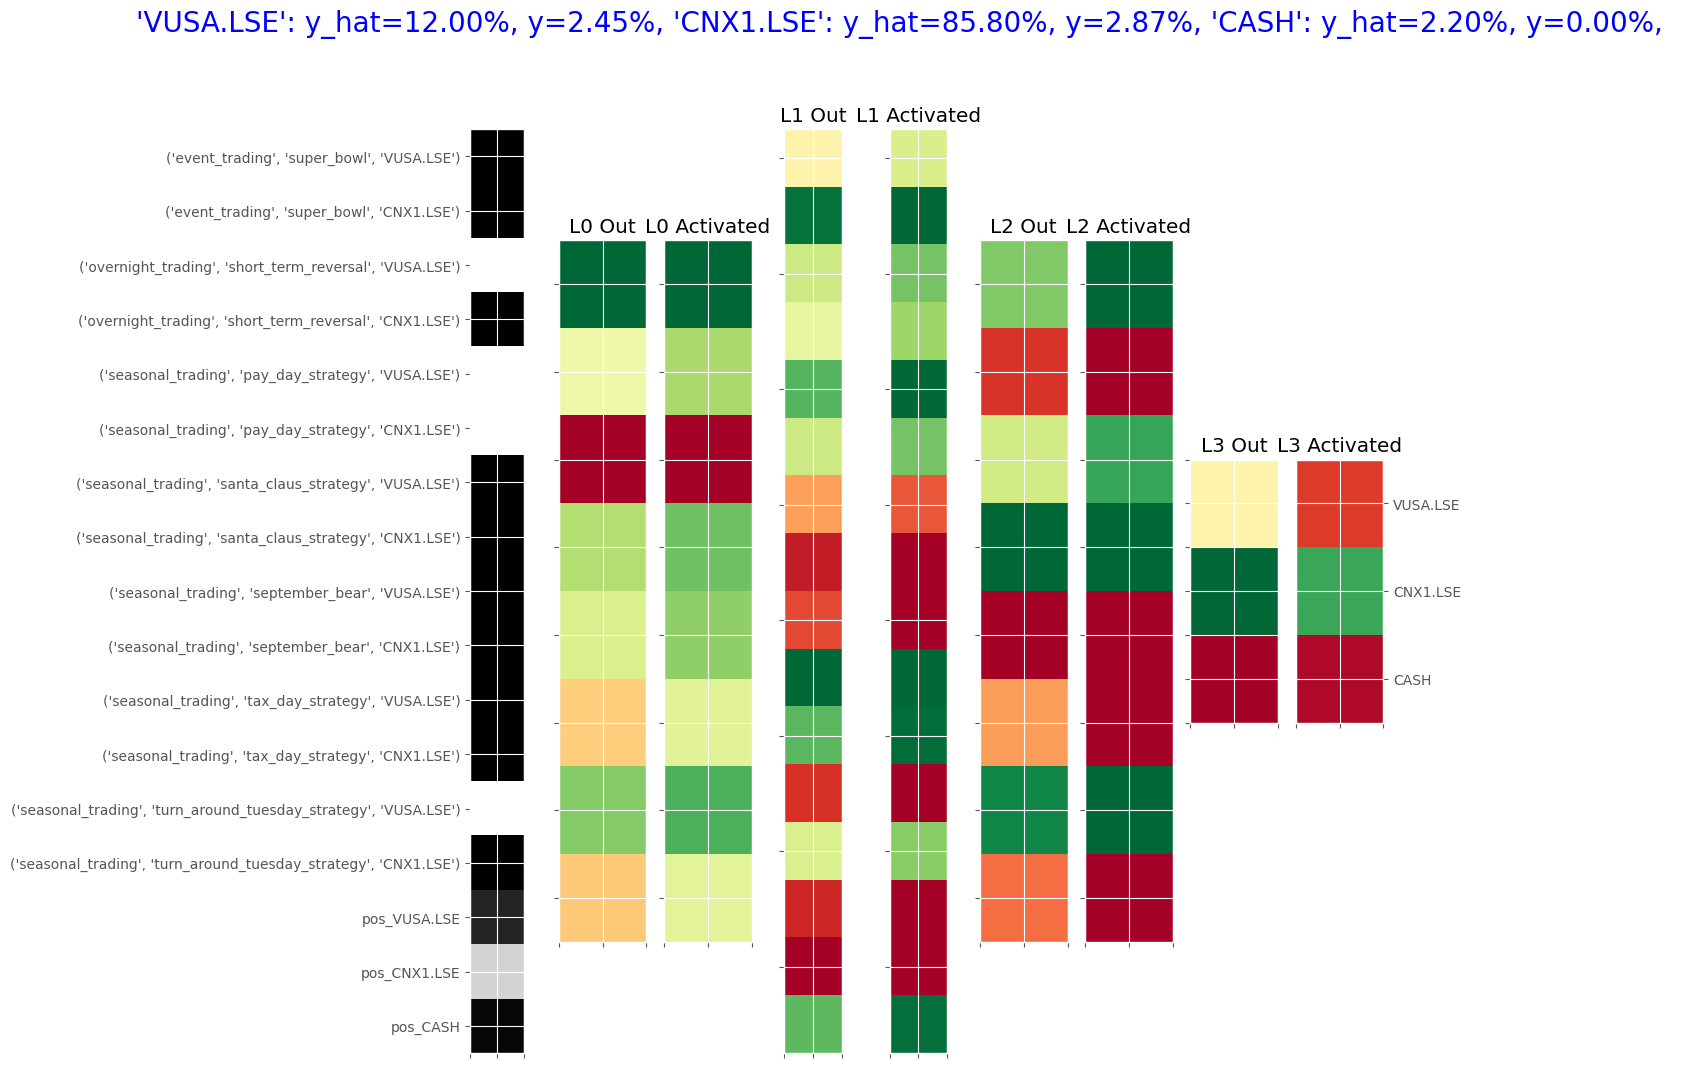

In [32]:
n_sample = 1
training_data = False

X_sample = X_train[n_sample] if training_data else X_test[n_sample]
y_sample = y_train[n_sample] if training_data else y_test[n_sample]

print(pd.Series(X_sample.detach().numpy(), index=orig_X_total.columns))

viz_nn.visualize_layer_activations(
    fig=plt.figure(figsize=(12, 12)), 
    network=my_net,
    X=X_sample.reshape(-1, orig_X_total.shape[1]),
    y=y_sample,
    X_labels=orig_X_total.columns.tolist(),
    y_labels=ASSETS,
    X_min=0.0, X_max=1.0,
    y_min=my_net.min_weight, y_max=my_net.max_weight,
)

## Plot Loss

C:\Users\tomw1\PycharmProjects\quantified_strategies\quantified_strategies\plot_utils.py:38: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(contents["epoch"].tolist()[::n])


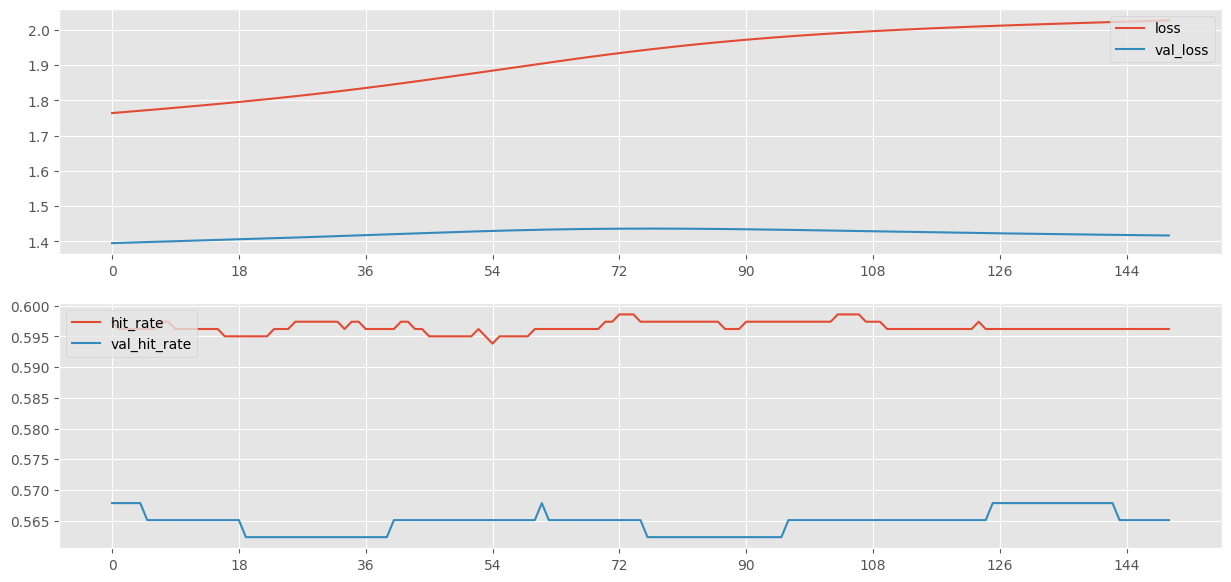

In [33]:
MODEL_NAME = f"{Net.MODEL_TYPE}-model-latest"
plot_utils.create_loss_graph(model_name=MODEL_NAME)

In [34]:
# raise ValueError

## Apply Asset Allocator

In [35]:
LOAD_MODEL = False

In [36]:
X_total_df, y_total_df = get_data(assets=ASSETS, is_classification=False)
X_train_df, X_test_df, y_train_df, y_test_df = ml_utils.split_data(X=X_total_df, y=y_total_df)
X_total_df.head(5)

{}
remove api from here
{}
remove api from here


C:\Users\tomw1\AppData\Local\Temp\ipykernel_21824\2815366492.py:7: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  return_data = price_data.pct_change()


event_trading            overnight_trading           \
              super_bowl          short_term_reversal            
                VUSA.LSE CNX1.LSE            VUSA.LSE CNX1.LSE   
Date                                                             
2012-05-23             0        0                   0        0   
2012-05-24             0        0                   0        0   
2012-05-25             0        0                   0        0   
2012-05-28             0        0                   0        0   
2012-05-29             0        0                   0        0   

           seasonal_trading                                         \
           pay_day_strategy          santa_claus_strategy            
                   VUSA.LSE CNX1.LSE             VUSA.LSE CNX1.LSE   
Date                                                                 
2012-05-23                0        0                    0        0   
2012-05-24                0        0                    0        0   
2012-05-25                1        1                    0        0   
2012-05-28                0        1                    0        0   
2012-05-29                1        1                    0        0   

                                                              \
           september_bear          tax_day_strategy            
                 VUSA.LSE CNX1.LSE         VUSA.LSE CNX1.LSE   
Date                                                           
2012-05-23              0        0                0        0   
2012-05-24              0        0                0        0   
2012-05-25              0        0                0        0   
2012-05-28              0        0                0        0   
2012-05-29              0        0                0        0   

                                                  
           turn_around_tuesday_strategy           
                               VUSA.LSE CNX1.LSE  
Date                                              
2012-05-23                            0        0  
2012-05-24                            0        0  
2012-05-25                            0        0  
2012-05-28                            0        0  
2012-05-29                            0        0

In [37]:
if LOAD_MODEL:
    model = Net.load(input_shape=X_total_df.shape[1], output_shape=y_total_df.shape[1], name="latest")
else:
    model = my_net
model

Net(
  (fc0): Linear(in_features=17, out_features=8, bias=True)
  (fc1): Linear(in_features=8, out_features=16, bias=True)
  (fc2): Linear(in_features=16, out_features=8, bias=True)
  (fc_output): Linear(in_features=8, out_features=3, bias=True)
)

In [38]:
def run(X_df: pd.DataFrame, y_df: pd.DataFrame, is_train: bool = True, sub_cost: int = 1.0) -> pd.DataFrame:
    
    def get_allocation():
    
        def _get_allocation(index: t.Any, last_pos: pd.Series, hold_days: int):
            x = pd.concat([X_df.loc[[index]], last_pos.to_frame(name=index).T], axis=1)
            x_tensor, _ = ml_utils.convert_data_to_tensors(X=x, y=y_df)
            last_pos2 = pd.Series(model(x_tensor).reshape(-1).detach().numpy(), index=y_df.columns)
            # if all(last_pos.round(2) == last_pos2.round(2)):
            #     hold_days += 1
            #     x.iloc[0, -4] = hold_days
            # else:
            #     hold_days = 1
            return last_pos2, hold_days
        
        A = []
        last_position = pd.Series(0.0, index=y_df.columns)
        hold_days = 0
        for index in X_df.index:
            last_position, hold_days = _get_allocation(index=index, last_pos=last_position, hold_days=hold_days)
            A.append(last_position.to_frame(name=index).T)
        A = pd.concat(A, axis=0)

        # filt = X_df.loc[:, X_df.columns.get_level_values(1) == "buy_when_yields_are_low"].sum(axis=1) > 0
        # A = A.loc[filt].reindex(index=A.index).fillna({asset: 1.0 if asset == CASH else 0.0 for asset in ASSETS})
        
        return A

    long_costs_df = pd.Series(LONG_OVERNIGHT_COSTS, index=ASSETS)
    short_costs_df = pd.Series(SHORT_OVERNIGHT_COSTS, index=ASSETS)
    
    # Get Allocation
    alloc = get_allocation()
    benchmark_alloc = X_df.iloc[:, :-2].groupby(level=2, axis=1).sum()
    benchmark_alloc = benchmark_alloc.div(benchmark_alloc.sum(axis=1), axis=0).fillna(0.0)
    benchmark_alloc = benchmark_alloc.reindex(columns=y_df.columns, fill_value=0.0)
    benchmark_alloc[CASH] = 1 - benchmark_alloc.sum(axis=1)
    hodl_alloc = pd.DataFrame(1 / (len(ASSETS) - 1), index=alloc.index, columns=ASSETS)
    hodl_alloc[CASH] = 0.0

    strat_overnight_long_costs = alloc.clip(lower=0.0).dot(long_costs_df)
    strat_overnight_short_costs = alloc.clip(upper=0.0).abs().dot(short_costs_df)
    costs = strat_overnight_long_costs + strat_overnight_short_costs

    # Get Strategy returns
    hodl_ret = (y_df * hodl_alloc).sum(axis=1) - sub_cost * (hodl_alloc.clip(lower=0.0).dot(long_costs_df) + hodl_alloc.clip(upper=0.0).abs().dot(short_costs_df))
    strat_bm_ret = (y_df * benchmark_alloc).sum(axis=1) - sub_cost * (benchmark_alloc.clip(lower=0.0).dot(long_costs_df) + benchmark_alloc.clip(upper=0.0).abs().dot(short_costs_df))
    strat_ret = (y_df * alloc).sum(axis=1)
    strat_ret_with_cost = strat_ret - costs
    
    strat_pos = alloc.loc[:, alloc.columns != CASH].sum(axis=1).round(3)
    strat_bm_pos = benchmark_alloc.loc[:, benchmark_alloc.columns != CASH].sum(axis=1).round(3)
    
    cum_hodl_ret = strategy_utils.get_cumulative_return(returns=hodl_ret, total=False)
    cum_strat_bm_ret = strategy_utils.get_cumulative_return(returns=strat_bm_ret, total=False)
    cum_strat_ret = strategy_utils.get_cumulative_return(returns=strat_ret, total=False)
    cum_strat_ret_with_cost = strategy_utils.get_cumulative_return(returns=strat_ret_with_cost, total=False)
    
    hodl_dd = strategy_utils.get_drawdown_statistics(returns=hodl_ret)["drawdown"]
    strat_bm_dd = strategy_utils.get_drawdown_statistics(returns=strat_bm_ret)["drawdown"]
    strat_dd = strategy_utils.get_drawdown_statistics(returns=strat_ret)["drawdown"]
    strat_with_costs_dd = strategy_utils.get_drawdown_statistics(returns=strat_ret)["drawdown"]
    
    prop_cycle = plt.rcParams["axes.prop_cycle"]
    colors = prop_cycle.by_key()["color"]
    color_map = {"strategy": colors[0], "hodl": colors[1], "strategy_bm": colors[2], "strategy_with_costs": colors[3]}
    
    fig, ax = plt.subplots(figsize=(15, 7))
    
    ax.plot(cum_hodl_ret, label="HODL", color=color_map["hodl"])
    ax.plot(cum_strat_ret, label="Strategy", color=color_map["strategy"])
    ax.plot(cum_strat_bm_ret, label="Strategy: BM", color=color_map["strategy_bm"])
    ax.plot(cum_strat_ret_with_cost, label="Strategy with Costs", color=color_map["strategy_with_costs"])
    ax.fill_between(
        cum_hodl_ret.index,
        0, cum_strat_ret - cum_hodl_ret,
        alpha=0.2, color="blue",
        label="Strategy - HODL",
    )
    ax.plot(hodl_dd, alpha=0.2, label="HODL: DD", color=color_map["hodl"])
    ax.plot(strat_dd, alpha=0.2, label="Strategy: DD", color=color_map["strategy"])
    ax.plot(strat_bm_dd, alpha=0.2, label="Strategy BM: DD", color=color_map["strategy_bm"])
    ax.plot(strat_with_costs_dd, alpha=0.2, label="Strategy with Costs: DD", color=color_map["strategy_with_costs"])

    i = 0
    for asset in y_df.columns:
        if asset == CASH:
            continue
        i += 1
        ax.plot(strategy_utils.get_cumulative_return(returns=y_df[asset], total=False), label=f"HODL: {asset!r}", color=color_map["hodl"], alpha=i / y_df.shape[1])
        # ax.plot(strategy_utils.get_drawdown_statistics(returns=y_df[asset])["drawdown"], label=f"HODL {asset!r}: DD", color=color_map["hodl"], alpha=i / y_df.shape[1])
        
    
    if is_train:
        plt.title("Strategy: Training")
    else:
        plt.title("Strategy: Test")
    plt.legend(loc="upper left")
    plt.show()
    
    desc = pd.concat([
        strategy_utils.describe(returns=strat_ret, pos=strat_pos, daily=True).to_frame(name="strategy"),
        strategy_utils.describe(returns=strat_ret_with_cost, pos=strat_pos, daily=True).to_frame(name="strategy(costs)"),
        strategy_utils.describe(returns=strat_bm_ret, pos=strat_bm_pos, daily=True).to_frame(name="strategy(bm)"),
        strategy_utils.describe(returns=hodl_ret, daily=True).to_frame(name="hodl")
    ], axis=1)
        
    return desc, alloc


In [39]:
INCLUDE_COST = 0.0

In [40]:
import datetime as dt

filt = X_train_df.loc[:, X_train_df.columns.get_level_values(1) == "buy_when_yields_are_low"].sum(axis=1) > 0

FROM_DATE = X_train_df.index[0].date()
FROM_DATE = dt.date(2018, 1, 1)
TO_DATE = X_train_df.index[-1].date()
# X_train_df_ = X_train_df.loc[(~filt) & (X_train_df.index.date >= FROM_DATE) & (X_train_df.index.date < TO_DATE)]
# y_train_df_ = y_train_df.loc[(~filt) & (y_train_df.index.date >= FROM_DATE) & (y_train_df.index.date < TO_DATE)]
X_train_df_ = X_train_df.loc[(X_train_df.index.date >= FROM_DATE) & (X_train_df.index.date < TO_DATE)]
y_train_df_ = y_train_df.loc[(y_train_df.index.date >= FROM_DATE) & (y_train_df.index.date < TO_DATE)]

C:\Users\tomw1\AppData\Local\Temp\ipykernel_21824\1288144720.py:34: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  benchmark_alloc = X_df.iloc[:, :-2].groupby(level=2, axis=1).sum()


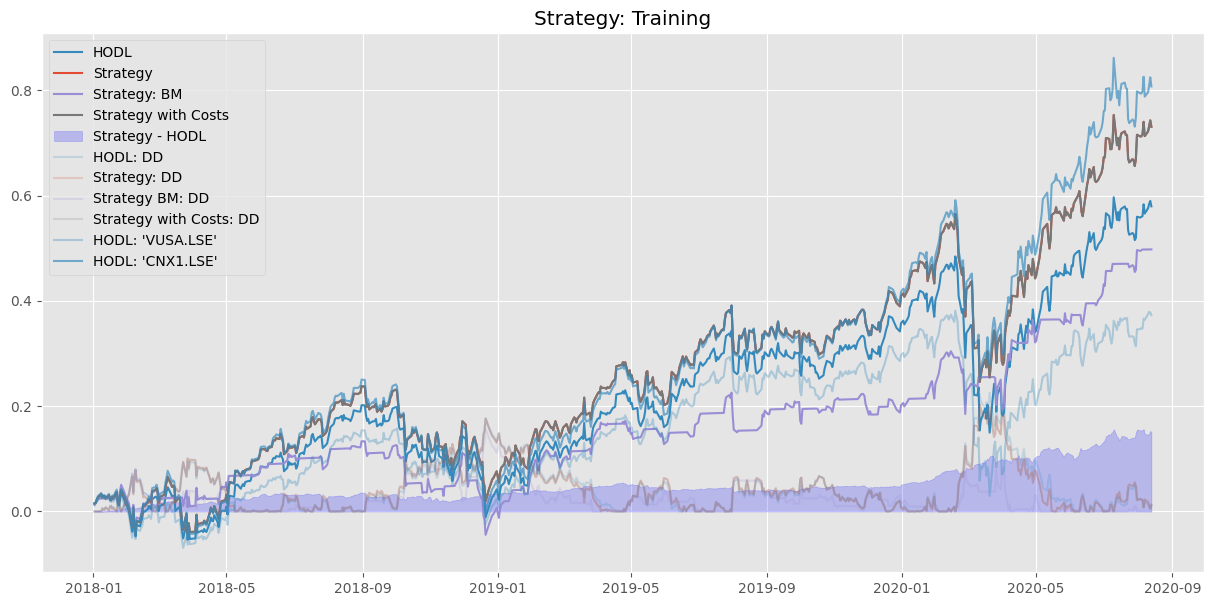

,strategy,strategy(costs),strategy(bm),hodl
Asset,Undefined,Undefined,Undefined,Undefined
Start,2018-01-02,2018-01-02,2018-01-02,2018-01-02
End,2020-08-13,2020-08-13,2020-08-13,2020-08-13
Mean Return,0.09076%,0.09076%,0.12047%,0.07697%
Total Return,73.08%,73.08%,45.75%,57.97%
Median Return,0.19185%,0.19185%,0.23427%,0.16485%
1st Quartile,-0.50696%,-0.50696%,-0.45367%,-0.46764%
3rd Quartile,0.80692%,0.80692%,0.80956%,0.75318%
Std Dev Return,1.26273%,1.26273%,1.28798%,1.26231%
CAGR,8.277 bps,8.277 bps,11.219 bps,6.898 bps


In [41]:
desc_train, alloc_train = run(X_df=X_train_df_, y_df=y_train_df_, is_train=True, sub_cost=INCLUDE_COST)
desc_train

<Axes: >

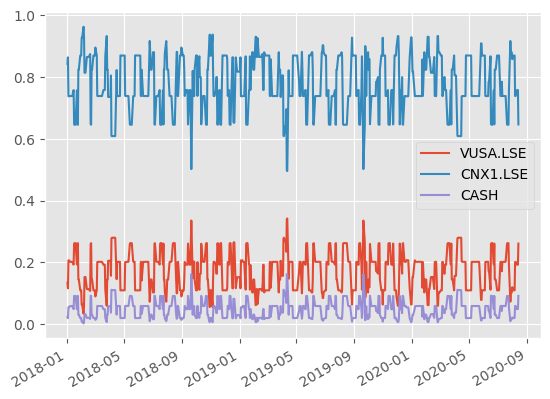

In [42]:
alloc_train.plot()

C:\Users\tomw1\AppData\Local\Temp\ipykernel_2832\1288144720.py:34: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  benchmark_alloc = X_df.iloc[:, :-2].groupby(level=2, axis=1).sum()


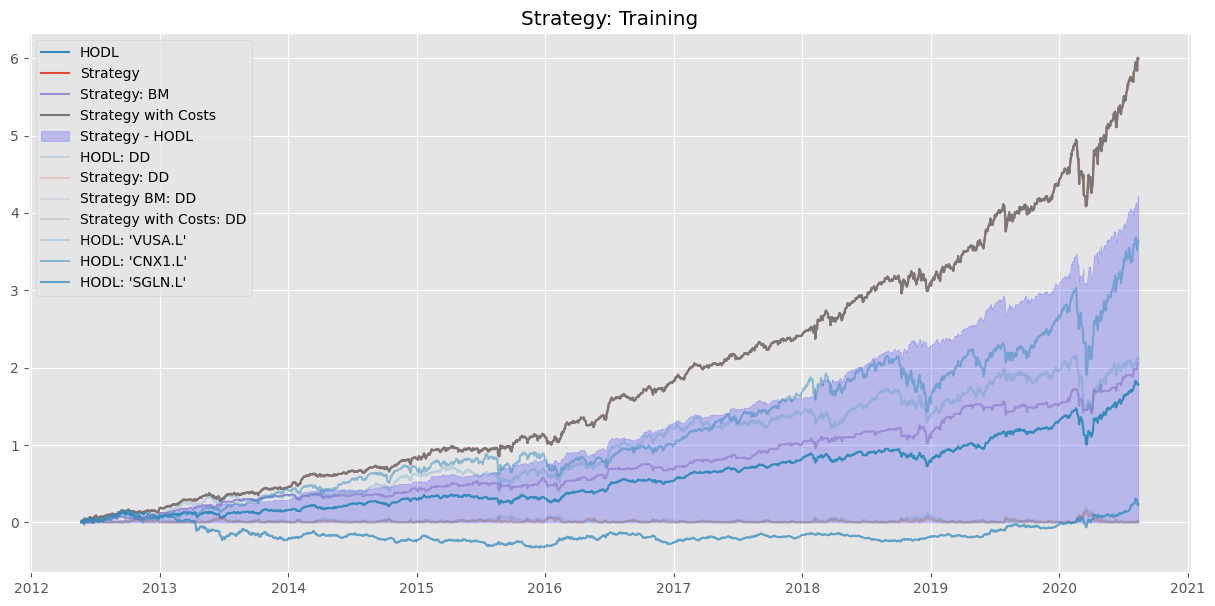

,strategy,strategy(costs),strategy(bm),hodl
Asset,Undefined,Undefined,Undefined,Undefined
Start,2012-05-23,2012-05-23,2012-05-23,2012-05-23
End,2020-08-13,2020-08-13,2020-08-13,2020-08-13
Mean Return,0.09632%,0.09632%,0.11269%,0.05139%
Total Return,599.23%,599.23%,177.92%,178.34%
Median Return,0.08781%,0.08781%,0.11443%,0.06455%
1st Quartile,-0.26699%,-0.26699%,-0.36252%,-0.25222%
3rd Quartile,0.44507%,0.44507%,0.60988%,0.38278%
Std Dev Return,0.73349%,0.73349%,0.99263%,0.65027%
CAGR,9.363 bps,9.363 bps,10.777 bps,4.927 bps


In [42]:
desc_train, alloc_train = run(X_df=X_train_df_, y_df=y_train_df_, is_train=True, sub_cost=INCLUDE_COST)
desc_train

In [52]:
import datetime as dt

filt = X_test_df.loc[:, X_test_df.columns.get_level_values(1) == "buy_when_yields_are_low"].sum(axis=1) > 0

FROM_DATE = X_test_df.index[0].date()
# FROM_DATE = dt.date(2023, 8, 1)
TO_DATE = X_test_df.index[-1].date()

# X_test_df_ = X_test_df.loc[(~filt) & (X_test_df.index.date >= FROM_DATE) & (X_test_df.index.date <= TO_DATE)]
# y_test_df_ = y_test_df.loc[(~filt) & (y_test_df.index.date >= FROM_DATE) & (y_test_df.index.date <= TO_DATE)]
X_test_df_ = X_test_df.loc[(X_test_df.index.date >= FROM_DATE) & (X_test_df.index.date <= TO_DATE)]
y_test_df_ = y_test_df.loc[(y_test_df.index.date >= FROM_DATE) & (y_test_df.index.date <= TO_DATE)]

C:\Users\tomw1\AppData\Local\Temp\ipykernel_2832\1288144720.py:34: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  benchmark_alloc = X_df.iloc[:, :-2].groupby(level=2, axis=1).sum()


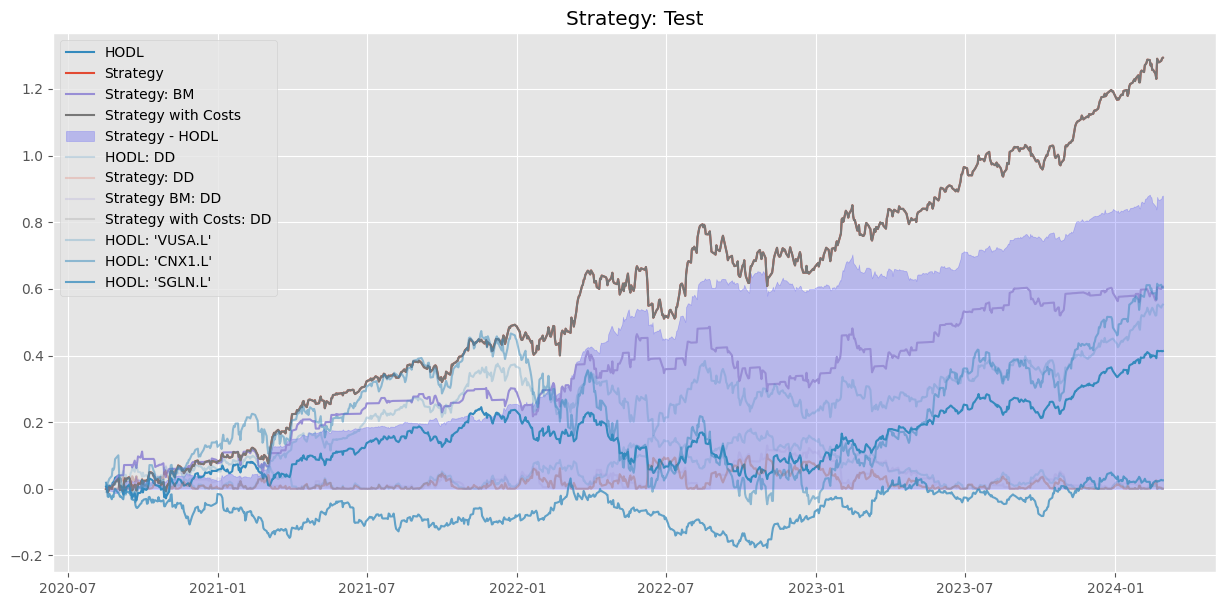

,strategy,strategy(costs),strategy(bm),hodl
Asset,Undefined,Undefined,Undefined,Undefined
Start,2020-08-17,2020-08-17,2020-08-17,2020-08-17
End,2024-02-28,2024-02-28,2024-02-28,2024-02-28
Mean Return,0.09670%,0.09670%,0.10644%,0.04170%
Total Return,129.33%,129.33%,53.29%,41.34%
Median Return,0.05983%,0.05983%,0.12540%,0.05591%
1st Quartile,-0.31016%,-0.31016%,-0.50683%,-0.40532%
3rd Quartile,0.51722%,0.51722%,0.74290%,0.49321%
Std Dev Return,0.85002%,0.85002%,1.14846%,0.76267%
CAGR,9.309 bps,9.309 bps,9.986 bps,3.880 bps


In [53]:
desc_test, alloc_test = run(X_df=X_test_df_, y_df=y_test_df_, is_train=False, sub_cost=INCLUDE_COST)
desc_test

<Axes: >

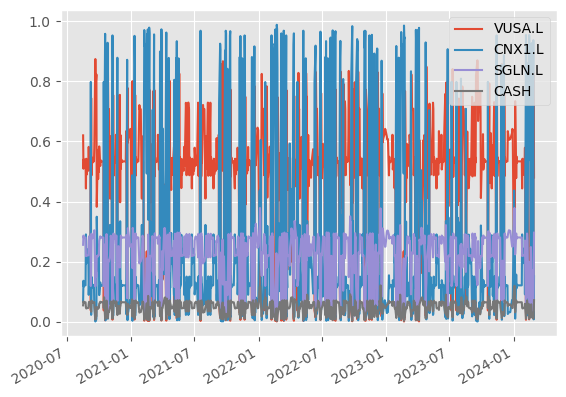

In [45]:
alloc_test.plot()

C:\Users\tomw1\AppData\Local\Temp\ipykernel_25852\3530708938.py:31: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  benchmark_alloc = X_df.iloc[:, :-1].groupby(level=2, axis=1).sum()


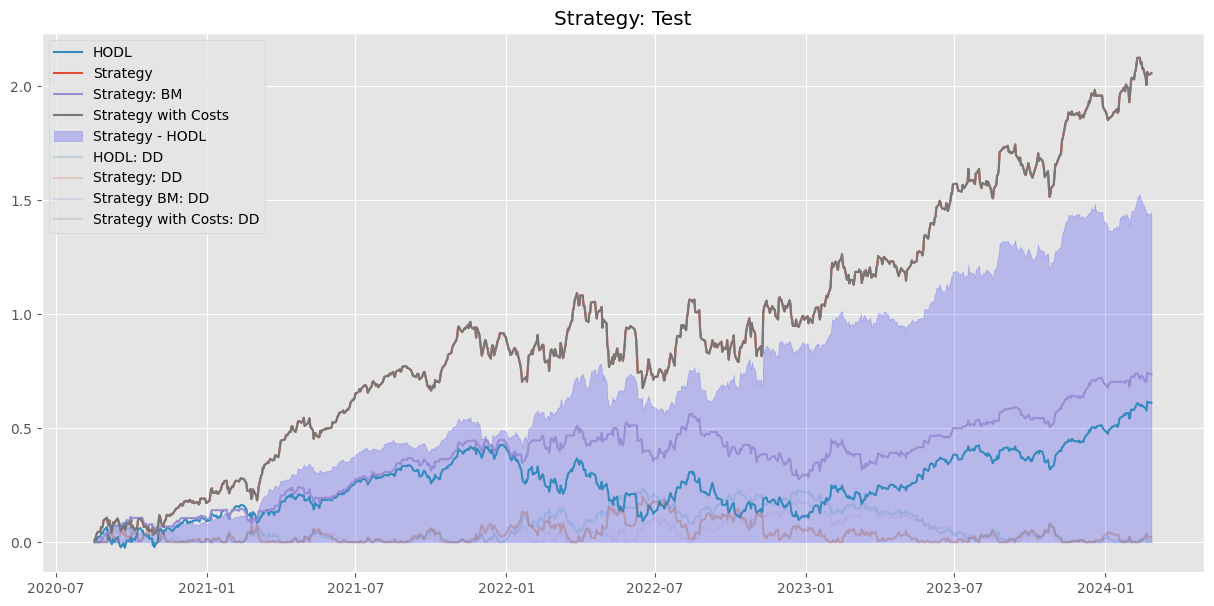

,strategy,strategy(costs),strategy(bm),hodl
Asset,Undefined,Undefined,Undefined,Undefined
Start,2020-08-17,2020-08-17,2020-08-17,2020-08-17
End,2024-02-26,2024-02-26,2024-02-26,2024-02-26
Mean Return,0.13393%,0.13393%,0.09126%,0.05917%
Total Return,205.64%,205.64%,73.57%,61.13%
Median Return,0.16517%,0.16517%,0.13290%,0.09119%
1st Quartile,-0.50787%,-0.50787%,-0.47538%,-0.55787%
3rd Quartile,0.80542%,0.80542%,0.69221%,0.63285%
Std Dev Return,1.29199%,1.29199%,1.05852%,1.05498%
CAGR,12.561 bps,12.561 bps,8.565 bps,5.361 bps


In [53]:
desc_test, alloc_test = run(X_df=X_test_df_, y_df=y_test_df_, is_train=False, sub_cost=INCLUDE_COST)
desc_test

strat_type = 'event_trading', strat_name = 'russell_rebalance', asset = 'IWM'
x-value
0    0.026845
1    0.078288
Name: ret, dtype: float64
strat_type = 'event_trading', strat_name = 'russell_rebalance', asset = 'IWM'
x-value
0    0.023650
1    0.127328
Name: ret, dtype: float64


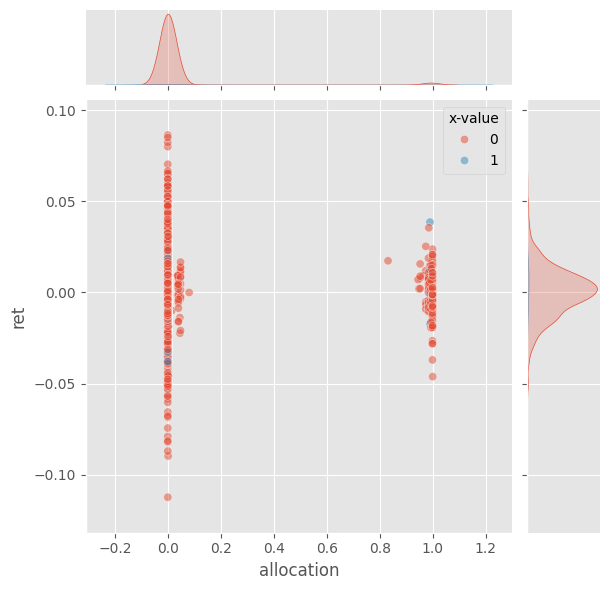

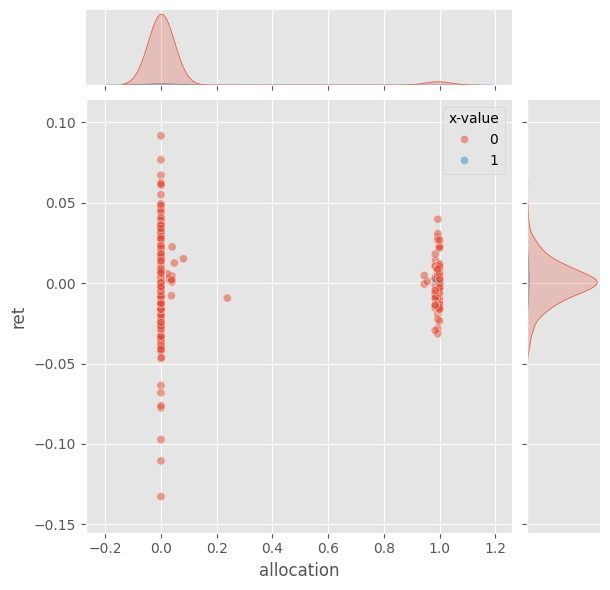

In [45]:
import seaborn as sns

def hist_plot(strategy_id: int, on_train: bool = True) -> None:

    strat_type, strat_name, asset = orig_X_total.columns[strategy_id]
    print(f"{strat_type = !r}, {strat_name = !r}, {asset = !r}")

    if on_train: 
        df = pd.concat([
                alloc_train[asset].to_frame(name="allocation"), 
                y_train_df[asset].to_frame(name="ret"), 
                X_train_df.iloc[:, strategy_id].to_frame("x-value"),
            ], axis=1)
    else:
        df = pd.concat([
                alloc_test[asset].to_frame(name="allocation"), 
                y_test_df[asset].to_frame(name="ret"), 
                X_test_df.iloc[:, strategy_id].to_frame("x-value"),
            ], axis=1)

    fig = sns.jointplot(
        data=df,
        x="allocation", y="ret", hue="x-value",
        alpha=0.5,
    )

    print(df.groupby("x-value")["ret"].mean() / df.groupby("x-value")["ret"].std())

    return

STRATEGY_ID = 0
hist_plot(strategy_id=STRATEGY_ID)
hist_plot(strategy_id=STRATEGY_ID, on_train=False)

In [46]:
y = alloc_train.reset_index(names="Date").melt(id_vars="Date", var_name="asset", value_name="allocation").set_index(["Date", "asset"])
size = y_train_df.reset_index(names="Date").melt(id_vars="Date", var_name="asset", value_name="ret").set_index(["Date", "asset"])
color = (
    X_train_df.iloc[:, :-4]
    .reset_index()
    .melt(id_vars=[('Date', '', '')])
    .rename(columns={"variable_0": "strat_type", "variable_1": "strat_name", "variable_2": "asset", "value": "x-value", ("Date", "", ""): "Date"})
    .set_index(["Date", "asset"])
)


In [47]:
size["bucket"] = (size["ret"] < -0.02).astype(int) + (size["ret"] < -0.01).astype(int) + (size["ret"] < 0.0).astype(int) + (size["ret"] < 0.01).astype(int) + (size["ret"] < 0.02).astype(int)
size["bucket"] = size["bucket"].replace({0: ">=0.02", 1: ">=0.01,<0.02", 2: ">=0.00,<0.01", 3: ">=-0.01,<0.00", 4: ">=-0.02,<-0.01", 5: "<-0.02"})
size

,,ret,bucket
Date,asset,,
2000-05-26,SPY,0.032609,>=0.02
2000-05-30,SPY,0.002192,">=0.00,<0.01"
2000-05-31,SPY,0.017506,">=0.01,<0.02"
2000-06-01,SPY,0.017419,">=0.01,<0.02"
2000-06-02,SPY,-0.004862,">=-0.01,<0.00"
...,...,...,...
2017-01-03,CASH,0.000000,">=0.00,<0.01"
2017-01-04,CASH,0.000000,">=0.00,<0.01"
2017-01-05,CASH,0.000000,">=0.00,<0.01"


In [48]:
df = pd.merge(pd.merge(y, size, left_index=True, right_index=True, how="inner"), color, left_index=True, right_index=True, how="inner").reset_index()

In [51]:
flt = df["Date"].isin(df.loc[(df["strat_name"] == "september_bear") & (df["x-value"] == 1), "Date"])
# df_ = df.loc[(df["asset"] == "QQQ"
df_ = df.loc[flt & (df["asset"] == "IWM")]
df_

,Date,asset,allocation,ret,bucket,strat_type,strat_name,x-value
50249,2000-09-15,IWM,0.000000e+00,-0.023627,<-0.02,event_trading,russell_rebalance,0
50250,2000-09-18,IWM,0.000000e+00,0.016333,">=0.01,<0.02",event_trading,russell_rebalance,0
50251,2000-09-19,IWM,0.000000e+00,-0.007946,">=-0.01,<0.00",event_trading,russell_rebalance,0
50252,2000-09-20,IWM,0.000000e+00,-0.018664,">=-0.02,<-0.01",event_trading,russell_rebalance,0
50253,2000-09-21,IWM,0.000000e+00,0.012884,">=0.01,<0.02",event_trading,russell_rebalance,0
...,...,...,...,...,...,...,...,...
54274,2016-09-16,IWM,1.639128e-07,0.006647,">=0.00,<0.01",event_trading,russell_rebalance,0
54275,2016-09-19,IWM,0.000000e+00,-0.004239,">=-0.01,<0.00",event_trading,russell_rebalance,0
54276,2016-09-20,IWM,0.000000e+00,0.014490,">=0.01,<0.02",event_trading,russell_rebalance,0
54277,2016-09-21,IWM,0.000000e+00,0.014364,">=0.01,<0.02",event_trading,russell_rebalance,0


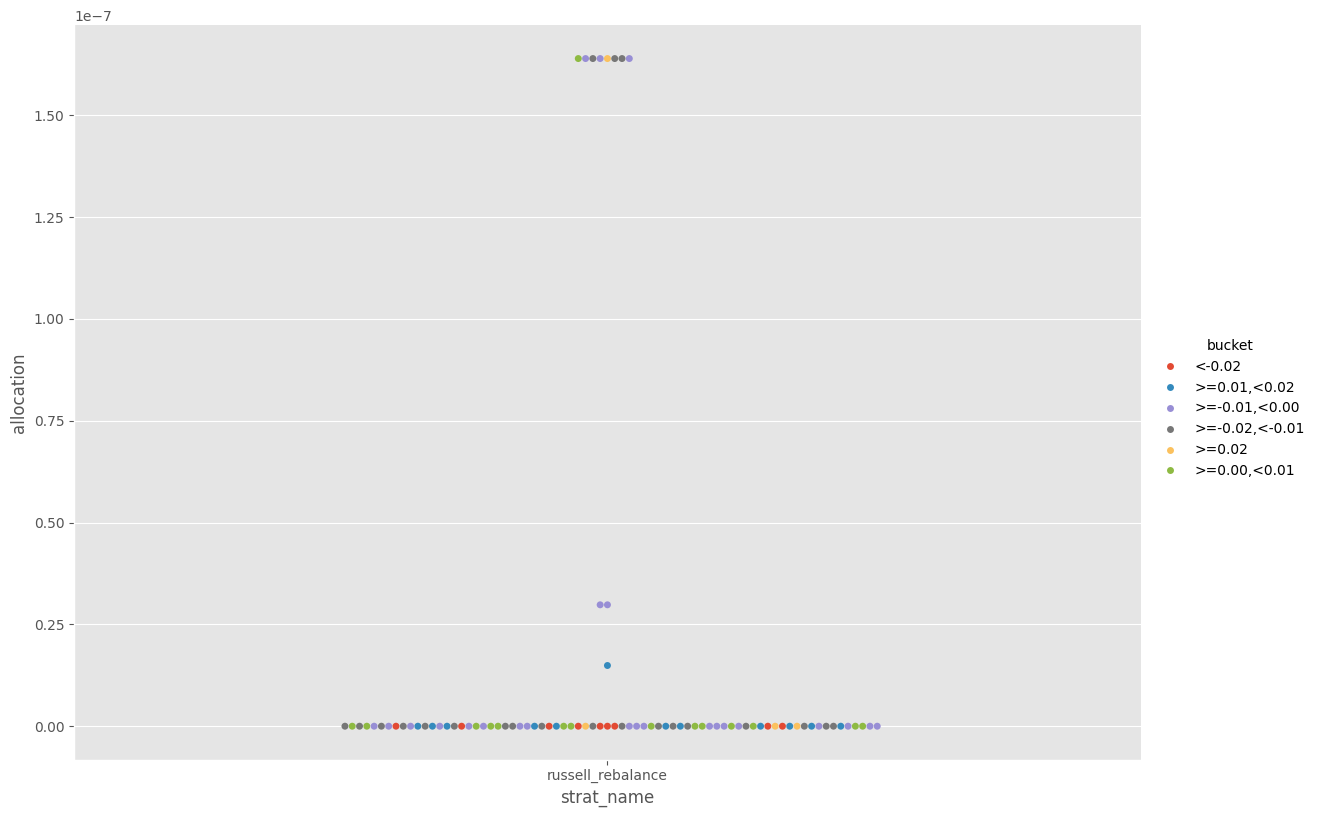

In [52]:
sns.catplot(data=df_, kind="swarm", x="strat_name", y="allocation", hue="bucket", height=8.27, aspect=11.7/8.27)